# Data Optmization

Once unzippped the data we worked with was 20G data across 7263 individual files. We first collated this into a singular csv through the process of iteratively appending the csv file.

## Build big dataset from file system

In [6]:
import pandas as pd
Z = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
alpha = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
f_MT= [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

## write all the data to csv 
def write_data(data_col = [6],
             A = alpha[0],  A_df = False,
             fMT = f_MT[0], fMT_df =False,  
             Z = Z[1], Z_df=False):   
    
    ##ensure col section is always a list ready for python shortcuts
    if not isinstance(data_col, list):data_col = [data_col]
    if not isinstance(Z, list):Z = [Z]
    if not isinstance(A, list):A = [A]
    if not isinstance(fMT, list):fMT = [fMT]
    #fetch the associated column labels
    col_head = ['ID', 'm_iZMAS_1', "m_iZMAS_2", "m_comp_1","m_comp_2", "m_rem", "t_delay", "smj_axis", "orb_ecc"]
    name_col = [col_head[x] for x in data_col] 
    
    out_path = ("~/project_lcp/results/"+
                "fMT_"+str(f_MT[0]) +"to" + str(f_MT[-1]) +  
                "A_"+str(A[0]) +"to"+str(A[-1])+ 
                "Z_"+str(Z[0])+"to"+str(Z[-1])+
                "_BHBs.csv")
    start_df = True 
    for Z_ in Z:
        Z_lb = str(Z_)
        for A_ in A:
            A_lb = str(A_)        
            for fMT_ in fMT:
                fMT_lb=str(fMT_).replace('.', '')
                filepath = "~/project_lcp/data/vnew_delayed_fMT"+fMT_lb + "/A"+A_lb +"/data_BHBs_"+Z_lb+".txt"
                #print("Z = ", Z_, ", A = ", A_, ", fMT =", fMT_)
                
                try:
                    df_out = pd.read_csv(filepath, sep=" ", skiprows=[0], header=None, usecols=data_col, names =name_col)
                    if A_df: df_out["alpha"]= A_
                    if fMT_df: df_out["f_MT"]= fMT_
                    if Z_df: df_out["Z"]= Z_
                    if start_df: #this way will start later if first is missing
                        df_out.to_csv(out_path, index=False)#create file
                        start_df = False
                    else:
                        df_out.to_csv(out_path, mode='a', header=False, index = False)
                except:
                    ex = None
                    #print(filepath+": Does not exist")
                           
#print("complete")

In [7]:
%%time
write_data(data_col=list(range(0,8)), fMT=f_MT, fMT_df =True ,  A=alpha, A_df=True, Z=Z, Z_df =True)

CPU times: user 8min 55s, sys: 8.7 s, total: 9min 4s
Wall time: 9min 7s


In [2]:
%%time
import pandas as pd
out_path="~/project_lcp/results/fMT_0.05to1A_0.5to10Z_0.0002to0.02_BHBs.csv"
df_big= pd.read_csv(out_path, usecols=[0,1,2,3,4,5,6,7]) #largest size without crashing

CPU times: user 1min 16s, sys: 17.8 s, total: 1min 34s
Wall time: 3min 7s


Even though our data is now in one large csv it still takes a large amount of time to load and the whole df cannot fit into RAM due to the pandas "RAM spike". This was causing a kernel crash

### Solution 

* Three of the columns are just repeated the values of fMT Z and Alpha, we changed the column data type to catagorical data type in this way the the rows are just refrences to these values and not 87756770 rows of individually assigned floats. 

* Using the Parquet file type with PyArrow (or fast Parque) . The parquet file encodes our data types and it is also lighter and much faster to load. Pandas will now use PyArrow in the backend  now the whole BHB data set can be loaded and manipulated easily.

*  Using distributed and parallel computing. We experimented with using Modin uses a choice of dask or ray to tackle large datasets in a parallel way, this offered further performance increases. 

The paraquet file below contians all the data in a small 4.83 GB file, by loading columns from the large csv and using join to add to parquet iteratively we built the paraquet file without going past our RAM quota.  

Pandas data type assigment
``` Python
df['alpha'] = df.alpha.astype('category')
df['f_MT'] = df.f_MT.astype('category')
df['Z'] = df.Z.astype('category')
```

### Using Parquet in Pandas

In [1]:
%%time
import pandas as pd
df = pd.read_parquet("all_BHBs.parquet")
df

CPU times: user 13.6 s, sys: 19.8 s, total: 33.5 s
Wall time: 59.9 s


,ID,m_ZAMS_1,m_ZAMS_2,m_comp_1,m_comp_2,m_merge,t_delay,smj_axis,orb_ecc,alpha,f_MT,Z
0,1,54.3396,52.0830,22.1118,20.4424,42.5542,0.008093,4.4282,0.011750,0.5,0.05,0.0002
1,5,58.9754,55.9686,24.3563,22.2701,46.6264,0.010175,5.4175,0.010724,0.5,0.05,0.0002
2,9,96.3555,84.2747,38.3529,34.0211,72.3740,0.272228,19.9710,0.045441,0.5,0.05,0.0002
3,10,61.2173,58.7969,25.2146,23.5961,48.8107,0.008453,5.1401,0.010244,0.5,0.05,0.0002
4,11,51.9740,48.2456,21.6566,18.5773,40.2339,0.044590,8.9334,0.352150,0.5,0.05,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...
87756765,3118210,50.6832,50.5820,3.9894,3.9378,7.9272,0.006562,61.7820,0.996770,5,0.5,0.02
87756766,3409500,142.2995,24.4715,9.9454,3.3375,13.2829,1.176829,146.5100,0.986530,5,0.5,0.02
87756767,3550378,54.8366,54.7393,4.4193,4.3622,8.7815,0.712588,181.3500,0.993970,5,0.5,0.02
87756768,3562656,36.7711,33.6648,4.2631,3.3264,7.5895,1.782024,6.1815,0.233690,5,0.5,0.02


In [7]:
import os

total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
  
# Memory usage
print("RAM used:",used_memory ,"MB")

RAM used: 6965 MB


In [3]:
df.dtypes

ID             int64
m_ZAMS_1     float64
m_ZAMS_2     float64
m_comp_1     float64
m_comp_2     float64
m_merge      float64
t_delay      float64
smj_axis     float64
orb_ecc      float64
alpha       category
f_MT        category
Z           category
dtype: object

In [8]:
%%time
medians = df.groupby(['alpha',"f_MT", "Z"])['t_delay'].median().to_frame()
medians

CPU times: user 3.64 s, sys: 4.36 s, total: 7.99 s
Wall time: 8.34 s


t_delay
alpha f_MT Z               
0.5   0.05 0.0002  0.049587
           0.0004  0.134741
           0.0008  0.204421
           0.0012  0.335788
           0.0016  0.494622
...                     ...
10    1    0.006   7.221333
           0.008   3.374717
           0.012   4.245677
           0.016   1.822305
           0.02         NaN

[2640 rows x 1 columns]

## Modin vs Pandas

### Pandas usage

In [1]:
import time
import pandas as pd
df=0
t1 = time.time()
df = pd.read_parquet("all_BHBs.parquet")
t2 = time.time()
dt = t2 -t1
print("Load time = ", dt, "/s")

t1 = time.time()
medians = df.groupby(['alpha',"f_MT", "Z"])['t_delay'].median().to_frame()
t2 = time.time()
dt = t2 -t1

medians
print("Grouping time = ", dt, "/s")

Load time =  48.3528413772583 /s
Grouping time =  6.723698139190674 /s


### Modin Usage 

In [1]:
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import modin.pandas as pd
import ray
ray.init()

2022-08-08 20:17:44,466	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.12', ray_version='1.12.1', ray_commit='4863e33856b54ccf8add5cbe75e41558850a1b75', address_info={'node_ip_address': '10.67.22.114', 'raylet_ip_address': '10.67.22.114', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-08-08_20-17-39_097417_14084/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-08-08_20-17-39_097417_14084/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-08-08_20-17-39_097417_14084', 'metrics_export_port': 53066, 'gcs_address': '10.67.22.114:47874', 'address': '10.67.22.114:47874', 'node_id': '6483abe0b9f72b0f290716eac31e2d3cda13232f0fcc284263d295bd'})

In [2]:
%%time 
df = pd.read_parquet("all_BHBs.parquet")

CPU times: user 602 ms, sys: 159 ms, total: 761 ms
Wall time: 37.9 s


In [3]:
%%time
medians = df.groupby(['alpha',"f_MT", "Z"])['t_delay'].median().to_frame()
medians

CPU times: user 143 ms, sys: 54.1 ms, total: 197 ms
Wall time: 8.45 s


t_delay
alpha f_MT Z               
0.5   0.05 0.0002  0.049587
           0.0004  0.134741
           0.0008  0.204421
           0.0012  0.335788
           0.0016  0.494622
...                     ...
10    1    0.006   7.221333
           0.008   3.374717
           0.012   4.245677
           0.016   1.822305
           0.02         NaN

[2640 rows x 1 columns]

In [4]:
%%time
df

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.5 µs


,ID,m_ZAMS_1,m_ZAMS_2,m_comp_1,m_comp_2,m_merge,t_delay,smj_axis,orb_ecc,alpha,f_MT,Z
0,1,54.3396,52.0830,22.1118,20.4424,42.5542,0.008093,4.4282,0.011750,0.5,0.05,0.0002
1,5,58.9754,55.9686,24.3563,22.2701,46.6264,0.010175,5.4175,0.010724,0.5,0.05,0.0002
2,9,96.3555,84.2747,38.3529,34.0211,72.3740,0.272228,19.9710,0.045441,0.5,0.05,0.0002
3,10,61.2173,58.7969,25.2146,23.5961,48.8107,0.008453,5.1401,0.010244,0.5,0.05,0.0002
4,11,51.9740,48.2456,21.6566,18.5773,40.2339,0.044590,8.9334,0.352150,0.5,0.05,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...
87756765,3118210,50.6832,50.5820,3.9894,3.9378,7.9272,0.006562,61.7820,0.996770,5,0.5,0.02
87756766,3409500,142.2995,24.4715,9.9454,3.3375,13.2829,1.176829,146.5100,0.986530,5,0.5,0.02
87756767,3550378,54.8366,54.7393,4.4193,4.3622,8.7815,0.712588,181.3500,0.993970,5,0.5,0.02
87756768,3562656,36.7711,33.6648,4.2631,3.3264,7.5895,1.782024,6.1815,0.233690,5,0.5,0.02


In [5]:
%%time
medians

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 15.7 µs


t_delay
alpha f_MT Z               
0.5   0.05 0.0002  0.049587
           0.0004  0.134741
           0.0008  0.204421
           0.0012  0.335788
           0.0016  0.494622
...                     ...
10    1    0.006   7.221333
           0.008   3.374717
           0.012   4.245677
           0.016   1.822305
           0.02         NaN

[2640 rows x 1 columns]

In [6]:
counts = df.groupby(["f_MT", "Z"])['t_delay'].count().to_frame()

## Visualising the data 

### Seperate lines for Z

Text(0, 0.5, 'Data Size')

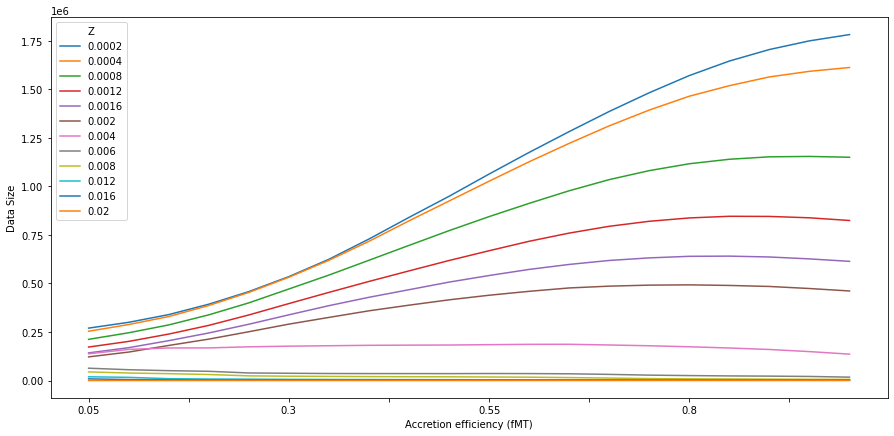

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['f_MT','Z']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Accretion efficiency (fMT)")
ax.set_ylabel("Data Size")

Text(0, 0.5, 'Data Size')

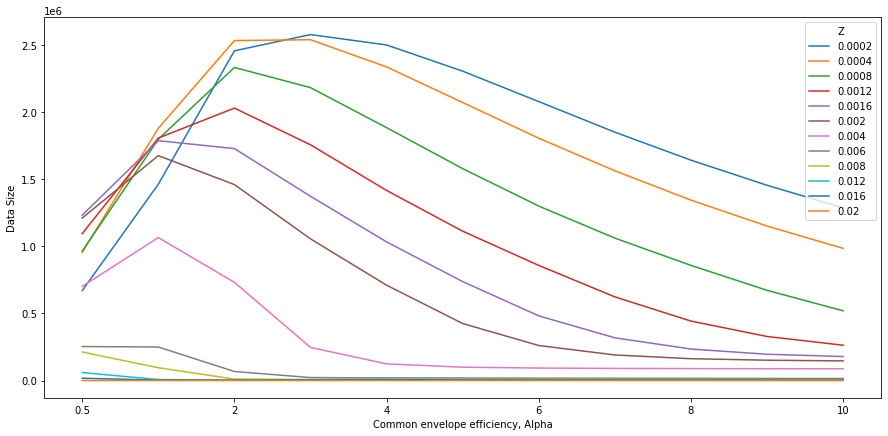

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['alpha','Z']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Common envelope efficiency, Alpha")
ax.set_ylabel("Data Size")

### Seperate accretion efficiency, fmt

Text(0, 0.5, 'Data Size')

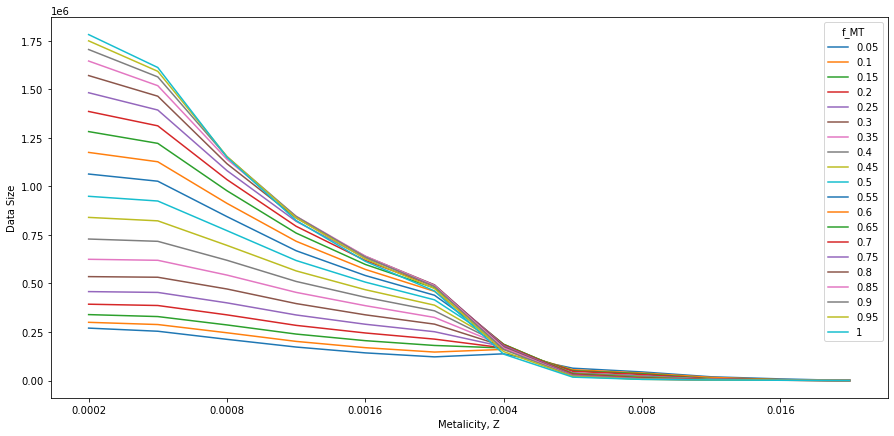

In [8]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Z','f_MT']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Metalicity, Z")
ax.set_ylabel("Data Size")

Text(0, 0.5, 'Data Size')

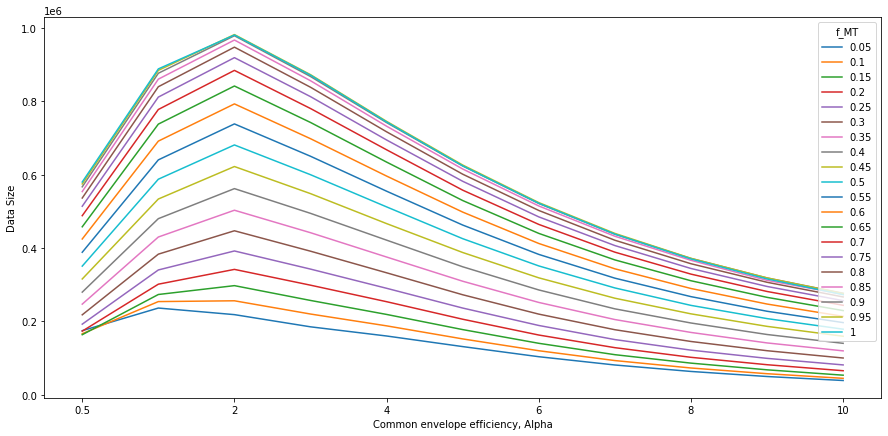

In [9]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['alpha','f_MT']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Common envelope efficiency, Alpha")
ax.set_ylabel("Data Size")

### Seperate common envelope efficiency, alpha

Text(0, 0.5, 'Data Size')

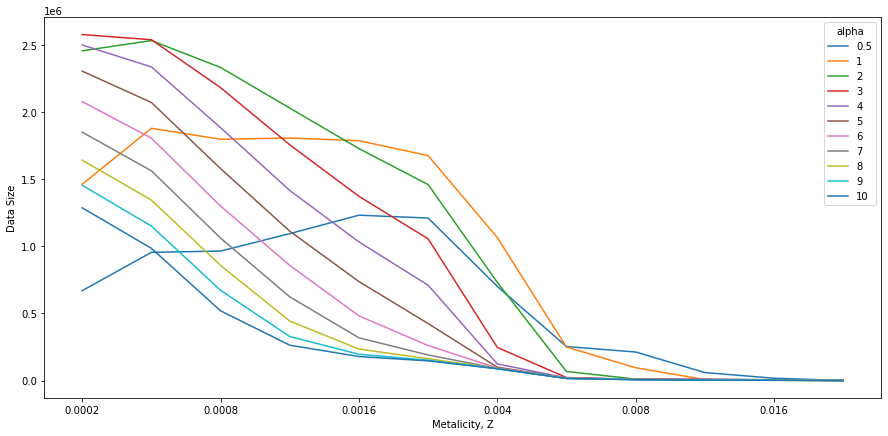

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Z','alpha']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Metalicity, Z")
ax.set_ylabel("Data Size")

Text(0, 0.5, 'Data Size')

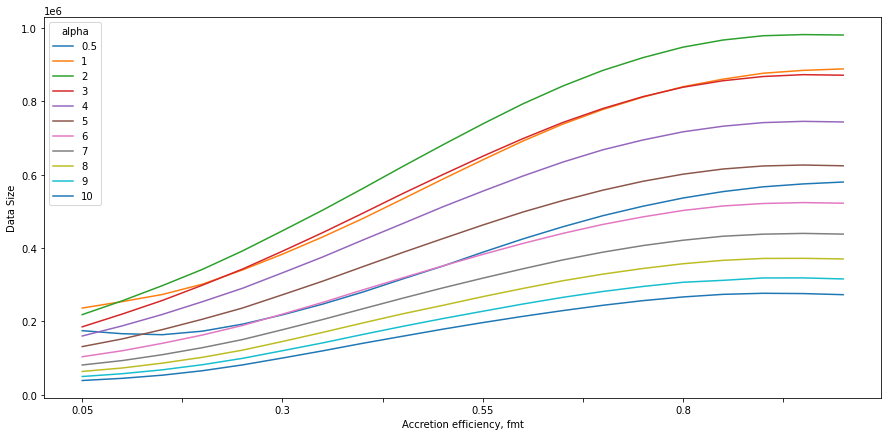

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['f_MT','alpha']).count()['t_delay'].unstack().plot(ax=ax)
ax.set_xlabel("Accretion efficiency, fmt")
ax.set_ylabel("Data Size")

## Data Visualisation: Mass comparison

#### Primary ZAMS mass vs compact object merger remnant 

Text(0, 0.5, 'Compact object merger remnant (Solar Masses)')

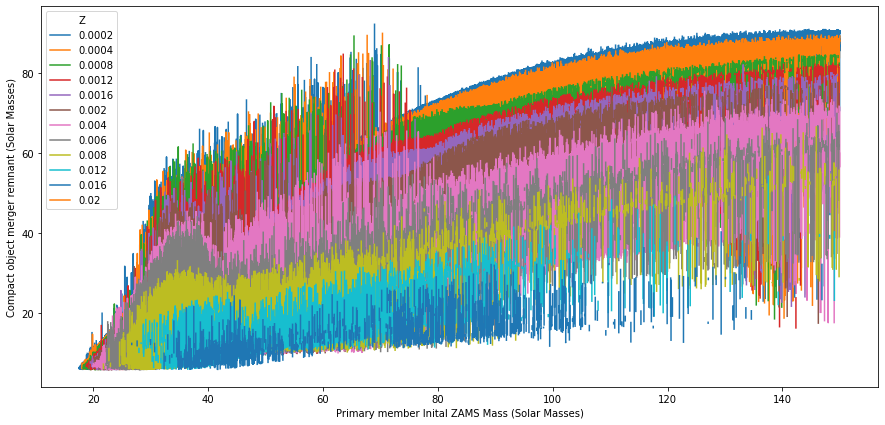

In [10]:
fig, ax = plt.subplots(figsize=(15,7))

df.groupby(['m_ZAMS_1','Z']).median()["m_merge"].unstack().plot(ax=ax)
ax.set_xlabel(r'Primary member Inital ZAMS Mass (Solar Masses)')
ax.set_ylabel(r'Compact object merger remnant (Solar Masses)')

#### Secondary ZAMS mass vs compact object merger remnant 

Text(0, 0.5, 'Compact object merger remnant (Solar Masses)')

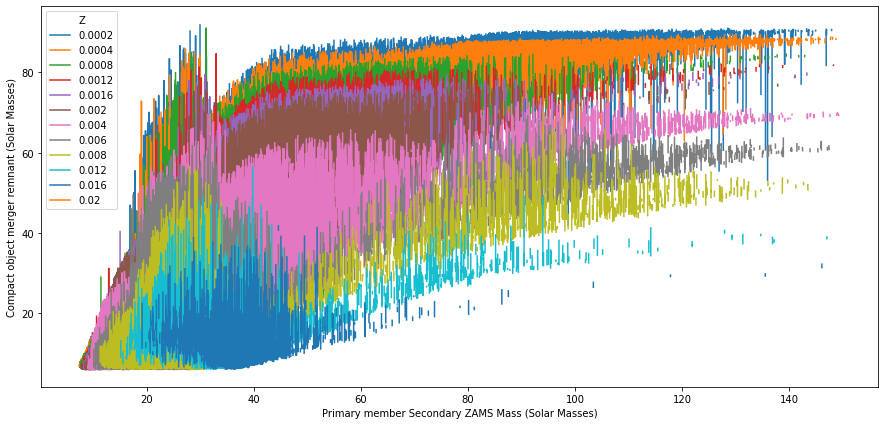

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['m_ZAMS_2','Z']).median()["m_merge"].unstack().plot(ax=ax)
ax.set_xlabel(r'Primary member Secondary ZAMS Mass (Solar Masses)')
ax.set_ylabel(r'Compact object merger remnant (Solar Masses)')